# Dogs&Cats Classifier

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

## Connecting to Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Dataset2class

In [3]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str, width, hight):
        super().__init__()

        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))

        self.width = width
        self.hight = hight

    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self, idx):

        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        img = cv2.resize(img, (self.width, self.hight), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))

        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)

        return {'img': t_img, 'label': t_class_id}

In [4]:
size = 64

In [5]:
train_dogs_path = '/content/drive/My Drive/datasets/DogsAndCats/training_set/dogs/'
train_cats_path = '/content/drive/My Drive/datasets/DogsAndCats/training_set/cats/'
test_dogs_path = '/content/drive/My Drive/datasets/DogsAndCats/test_set/dogs/'
test_cats_path = '/content/drive/My Drive/datasets/DogsAndCats/test_set/cats/'

train_ds = Dataset2class(train_dogs_path, train_cats_path, size, size)
test_ds = Dataset2class(test_dogs_path, test_cats_path, size, size)

In [6]:
print(len(train_ds))
print(len(test_ds))

8000
2000


## Loaders

In [7]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=False
)

## TwoClassNet

In [8]:
class TwoClassNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2,2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))

        self.conv0 = nn.Conv2d(3, size, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(size, size, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(size, size, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(size, size * 2, 3, stride=1, padding=0)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(size * 2, 20)
        self.linear2 = nn.Linear(20, 2)

    def forward(self, x):
        out = self.conv0(x)
        out = self.leakyrelu(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.leakyrelu(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.leakyrelu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.leakyrelu(out)
        out = self.adaptivepool(out)

        out = self.flatten(out)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out


In [9]:
model = TwoClassNet()

## Count parameters

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(model)

152126

## Accuracy function

In [12]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

## Model fitting

In [13]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
model = model.to(device)
loss = loss.to(device)

In [16]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()

In [17]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [18]:
loss_train_model = [0]
loss_test_model = [0]
acc_train_model = [0]
acc_test_model = [0]

In [19]:
epochs = 20

for epoch in range(epochs):
  print('Epoch ' + str(epoch+1))
  print()
  loss_train = 0
  acc_train = 0
  loss_test = 0
  acc_test = 0
  for sample in (tqdm(train_loader)):
    img, label = sample['img'], sample['label']
    label = F.one_hot(label, 2).float()
    img = img.to(device)
    label = label.to(device)
    opt.zero_grad()

    with autocast(use_amp):
      fcast = model(img)
      loss_am = loss(fcast, label)

    scaler.scale(loss_am).backward()
    loss_item = loss_am.item()
    loss_train += loss_item

    scaler.step(opt)
    scaler.update()

    acc_current = accuracy(fcast.cpu().float(), label.cpu().float())
    acc_train += acc_current
  print('loss_train:' + str(loss_train/len(train_loader)))
  print('acc_train:' + str(acc_train/len(train_loader)))
  acc_train_model.append(acc_train/len(train_loader))
  loss_train_model.append(loss_train/len(train_loader))
  for sample in test_loader:
    img, label = sample['img'], sample['label']
    label = F.one_hot(label, 2).float()
    img = img.to(device)
    label = label.to(device)

    fcast = model(img)
    loss_am = loss(fcast, label)

    loss_am.backward()
    loss_item = loss_am.item()
    loss_test += loss_item

    acc_current = accuracy(fcast.cpu().float(), label.cpu().float())
    acc_test += acc_current
  print('loss_test:' + str(loss_test/len(test_loader)))
  print('acc_test:' + str(acc_test/len(test_loader)))
  acc_test_model.append(acc_test/len(test_loader))
  loss_test_model.append(loss_test/len(test_loader))
  print('------------------------------------------------------------')

Epoch 1



  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-12-335fe52d9cfa>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)


loss_train:0.6923966445922851
acc_train:0.520125
loss_test:0.6935500636100769
acc_test:0.508
------------------------------------------------------------
Epoch 2



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.67543030834198
acc_train:0.5845
loss_test:0.6783016505241394
acc_test:0.57
------------------------------------------------------------
Epoch 3



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.6352610075473786
acc_train:0.644875
loss_test:0.5974524183273315
acc_test:0.6795
------------------------------------------------------------
Epoch 4



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.567009062051773
acc_train:0.707375
loss_test:0.5437730967998504
acc_test:0.7315
------------------------------------------------------------
Epoch 5



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.5158169591426849
acc_train:0.749375
loss_test:0.5404220370054245
acc_test:0.7365
------------------------------------------------------------
Epoch 6



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.4781346673965454
acc_train:0.773125
loss_test:0.47721541607379914
acc_test:0.784
------------------------------------------------------------
Epoch 7



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.4387753750681877
acc_train:0.795375
loss_test:0.4417526053190231
acc_test:0.8005
------------------------------------------------------------
Epoch 8



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.40360614874958994
acc_train:0.8115
loss_test:0.47146257328987123
acc_test:0.793
------------------------------------------------------------
Epoch 9



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.36465301632881164
acc_train:0.83575
loss_test:0.4234567139148712
acc_test:0.8065
------------------------------------------------------------
Epoch 10



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.3314644948393106
acc_train:0.85275
loss_test:0.3937900933623314
acc_test:0.8305
------------------------------------------------------------
Epoch 11



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.30127245327830315
acc_train:0.863
loss_test:0.4220099800825119
acc_test:0.8245
------------------------------------------------------------
Epoch 12



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.2692656102627516
acc_train:0.883625
loss_test:0.44522980082035063
acc_test:0.82
------------------------------------------------------------
Epoch 13



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.2460791363120079
acc_train:0.89275
loss_test:0.4031812244653702
acc_test:0.822
------------------------------------------------------------
Epoch 14



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.21610357701778413
acc_train:0.910875
loss_test:0.44095498219132423
acc_test:0.84
------------------------------------------------------------
Epoch 15



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.1982828234285116
acc_train:0.915
loss_test:0.5005128704309464
acc_test:0.815
------------------------------------------------------------
Epoch 16



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.18160815414786338
acc_train:0.927375
loss_test:0.5064816655814648
acc_test:0.8245
------------------------------------------------------------
Epoch 17



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.14394124853610993
acc_train:0.94125
loss_test:0.4759249754548073
acc_test:0.821
------------------------------------------------------------
Epoch 18



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.13157350334525109
acc_train:0.943375
loss_test:0.5057830936312675
acc_test:0.8315
------------------------------------------------------------
Epoch 19



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.10993350790441037
acc_train:0.953875
loss_test:0.549203505307436
acc_test:0.8355
------------------------------------------------------------
Epoch 20



  0%|          | 0/500 [00:00<?, ?it/s]

loss_train:0.10148191040754319
acc_train:0.95875
loss_test:0.6328558293692768
acc_test:0.8275
------------------------------------------------------------


## Plots

In [20]:
loss_train_model = np.array(loss_train_model)
loss_test_model = np.array(loss_test_model)
acc_train_model = np.array(acc_train_model)
acc_test_model = np.array(acc_test_model)
epochs = np.arange(len(loss_train_model))

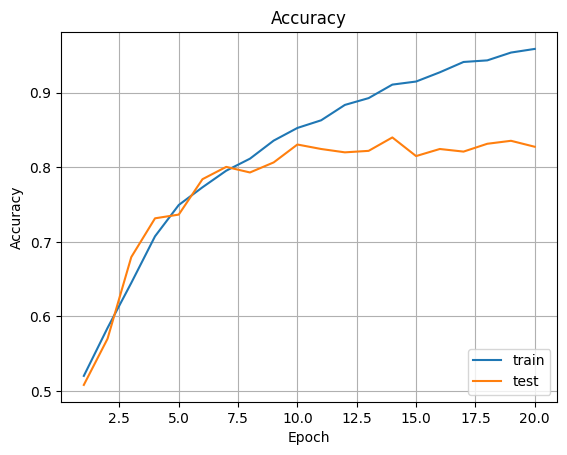

In [21]:
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(epochs[1:], acc_train_model[1:])
plt.plot(epochs[1:], acc_test_model[1:])
plt.legend(['train', 'test'], loc=4)
plt.show()

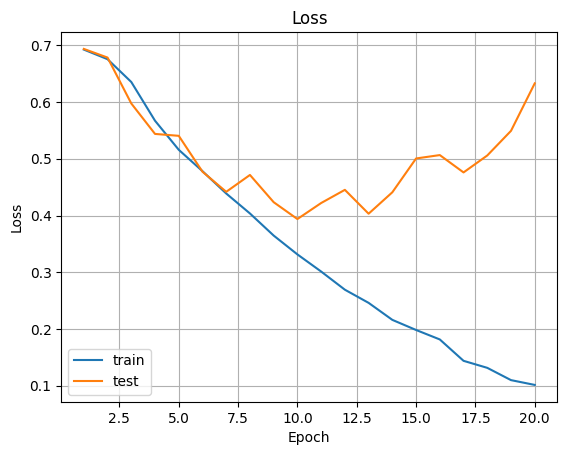

In [22]:
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.plot(epochs[1:], loss_train_model[1:])
plt.plot(epochs[1:], loss_test_model[1:])
plt.legend(['train', 'test'], loc=3)
plt.show()

Conclusion: By reducing the photos to 64x64 pixels, we were able to obtain a model with an accuracy of 84%.